# 1. Run the Partcile Filter Algorithm to estimate parameters

**RunPF: A class created to run particle filter on some default parameters 
returns: particle filter simulation object on which particle filter is run and the particle filter output**

In [1]:
from epymorph.parameter_forecasting.particle_filer_run import RunPF

In [2]:
particlefilter = RunPF()

In [3]:
simulation_object, pf_output = particlefilter.run()

Running Particle Filter simulation
• 2022-10-01 00:00:00 to 2023-10-07 00:00:00 (372 days)
• 500 particles

Simulation completed in 739.84s

Parameters estimated: ['beta', 'xi']


# 2. Passing the particle filter output (final particle cloud of the particle filter output which contains the state and the parameter values) forecasting simulation

In [4]:
from epymorph.adrio import acs5
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import SIRH
from epymorph.data.mm.no import No
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRUME
from epymorph.time import TimeFrame
import numpy as np

duration = 7 * 53 + 1
t = np.arange(0, duration)
true_beta = 0.03 * np.cos(t * 2 * np.pi / (365)) + 0.28

rume = SingleStrataRUME.build(
    ipm=SIRH(),
    mm=No(),
    scope=StateScope.in_states(["AZ"], year=2015),
    init=Proportional(ratios=np.array([9999, 1, 0, 0], dtype=np.int64)),
    time_frame=TimeFrame.of("2023-10-07", 7 * 53 + 1),
    params={
        "beta": true_beta,
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.01,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
    },
)

In [5]:
from epymorph.parameter_fitting.utils.observations import ModelLink

from epymorph.time import EveryNDays

quantity_selection = rume.ipm.select.events("I->H")
time_selection = rume.time_frame.select.all().group(EveryNDays(7)).agg()
geo_selection = rume.scope.select.all()

model_link = ModelLink(
    quantity=quantity_selection,
    time=time_selection,
    geo=geo_selection,
)

In [6]:
from epymorph.parameter_fitting.distribution import Uniform
from epymorph.parameter_fitting.dynamics import GeometricBrownianMotion
from epymorph.parameter_fitting.perturbation import Calvetti
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.05, b=0.5),
        dynamics=GeometricBrownianMotion(volatility=0.04),
    ),
    "xi": EstimateParameters.Static(
        distribution=Uniform(a=0.001, b=0.01),
        perturbation=Calvetti(a=0.9),
    ),
}

In [7]:
from epymorph.parameter_forecasting.forecast_params import ForecastParameters

In [8]:
sim = ForecastParameters(
    initial_particles=pf_output.particles,
    rume=rume,
    params_space=params_space,
    model_link=model_link,
    start_date="2023-10-07",
    duration_weeks=53,
    time_interval=7,
)

In [9]:
forecast_output = sim.forecast_params()

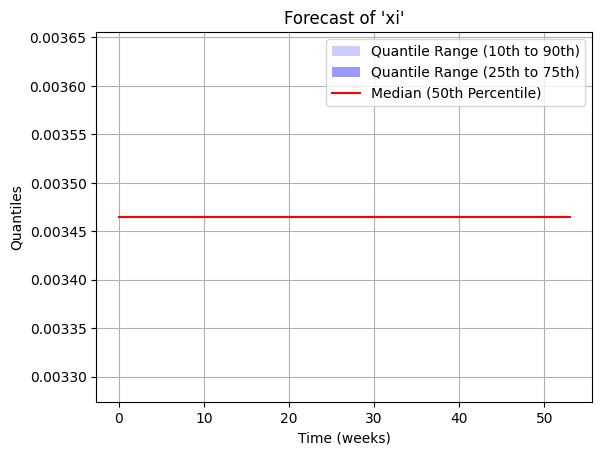

In [13]:
from epymorph.database import NamePattern
import matplotlib.pyplot as plt

key = "xi"
node_index = 0
truth = None

key_quantiles = np.array(forecast_output.param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)
plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)

# obs = np.arange(0, len(key_quantiles))
# plt.plot(
#     obs,
#     np.broadcast_to(
#         rume.params[NamePattern(strata="*", module="*", id="xi")], shape=obs.shape
#     ),
#     "k--",
# )

plt.title(f"Forecast of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


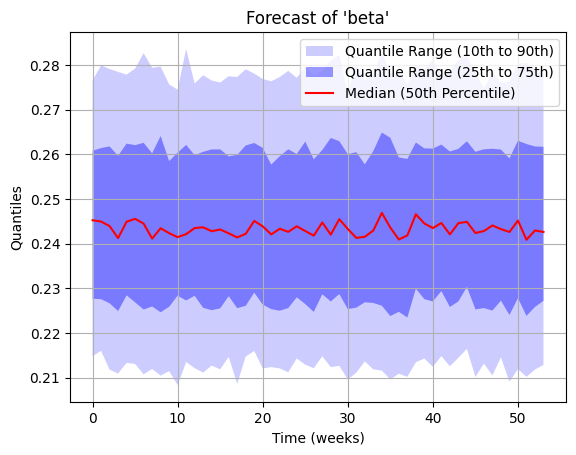

In [14]:
key = "beta"
node_index = 0
truth = None

key_quantiles = np.array(forecast_output.param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)
plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)

# obs = np.arange(0, len(key_quantiles))
# plt.plot(
#     obs,
#     np.array(rume.params[NamePattern(strata="*", module="*", id="beta")])[::7],
#     "k--",
# )

plt.title(f"Forecast of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()
